Prezentowany poniżej algorytm składa się z etapów typowych dla większości procesów ML:


* Analiza danych
* Wstępne przetworzenie danych (wyrównanie histogramu, transformacja RGB -> GRAY itp.)
* Budowa architektury CNN
* Trening sieci
* Testowanie modelu
* Iteracja powyższych punktów do czasu osiągnięcia rezultatu o wystarczającej dokładności
* Wdrożenie modelu

References:
https://towardsdatascience.com/my-tryst-with-deep-learning-german-traffic-data-set-with-keras-87970dfb18b7

# Instalacje

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!pip install tensorflow-gpu 

In [0]:
!pip install tf-nightly

# Importy

In [0]:
import pickle

import numpy as np
np.random.seed(2020)
import pandas as pd

#Tensorflow
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.utils import to_categorical

from tqdm import tqdm
from collections import Counter

!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback #<= automatyczne tworzenie krzywej uczenia się

from skimage import color, exposure
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Wczytanie danych źródłowych

Dane zapisane są z rozszerzeniem *.p - do ich odczytu używamy biblioteki pickle

In [45]:
# Train i test dataset
training_file = '/content/drive/My Drive/german_traffic_signs/train.p'
test_file     =  '/content/drive/My Drive/german_traffic_signs/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)

with open(test_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

print(X_train.shape, X_test.shape)

(39209, 32, 32, 3) (12630, 32, 32, 3)


In [46]:
# Opisy danych
signnames = pd.read_csv('/content/drive/My Drive/german_traffic_signs/signames.csv', sep=';')
signnames.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [47]:
# Zmienna docelowa - Target variable
traffic_labels_dict = signnames[ ['SignName'] ].to_dict()['SignName']
traffic_labels_dict

{0: 'Speed limit (20km/h)',
 1: 'Speed limit (30km/h)',
 2: 'Speed limit (50km/h)',
 3: 'Speed limit (60km/h)',
 4: 'Speed limit (70km/h)',
 5: 'Speed limit (80km/h)',
 6: 'End of speed limit (80km/h)',
 7: 'Speed limit (100km/h)',
 8: 'Speed limit (120km/h)',
 9: 'No passing',
 10: 'No passing for vechiles over 3.5 metric tons',
 11: 'Right-of-way at the next intersection',
 12: 'Priority road',
 13: 'Yield',
 14: 'Stop',
 15: 'No vechiles',
 16: 'Vechiles over 3.5 metric tons prohibited',
 17: 'No entry',
 18: 'General caution',
 19: 'Dangerous curve to the left',
 20: 'Dangerous curve to the right',
 21: 'Double curve',
 22: 'Bumpy road',
 23: 'Slippery road',
 24: 'Road narrows on the right',
 25: 'Road work',
 26: 'Traffic signals',
 27: 'Pedestrians',
 28: 'Children crossing',
 29: 'Bicycles crossing',
 30: 'Beware of ice/snow',
 31: 'Wild animals crossing',
 32: 'End of all speed and passing limits',
 33: 'Turn right ahead',
 34: 'Turn left ahead',
 35: 'Ahead only',
 36: 'Go st

===== Speed limit (20km/h) =====


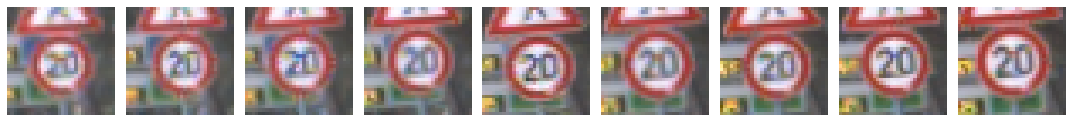

===== Speed limit (30km/h) =====


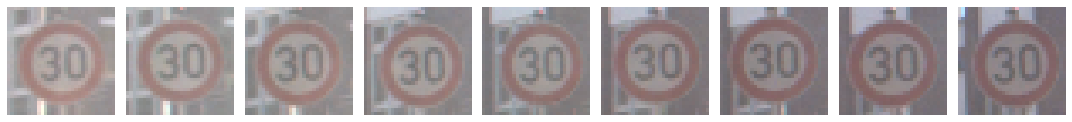

===== Speed limit (50km/h) =====


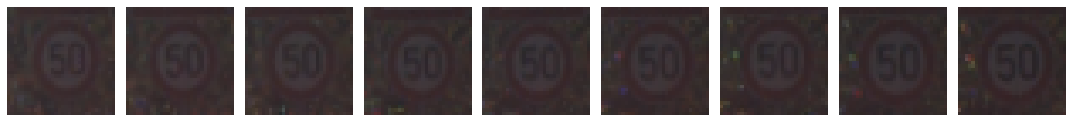

===== Speed limit (60km/h) =====


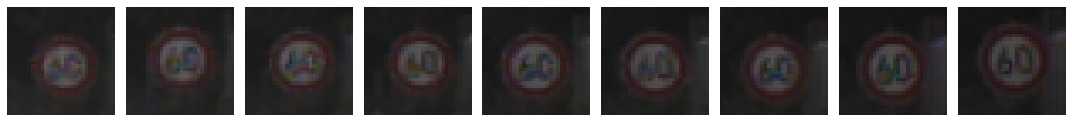

===== Speed limit (70km/h) =====


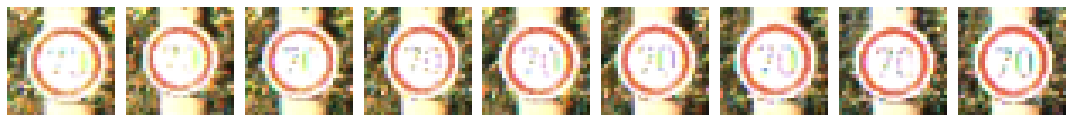

===== Speed limit (80km/h) =====


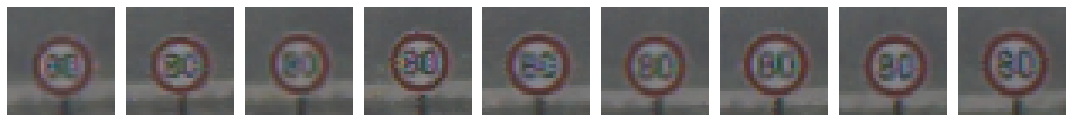

===== End of speed limit (80km/h) =====


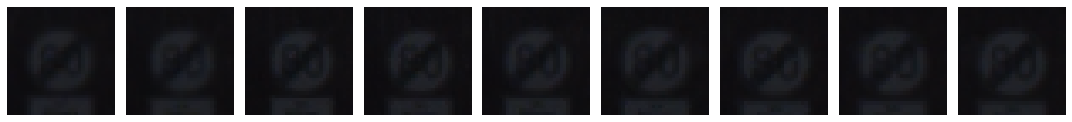

===== Speed limit (100km/h) =====


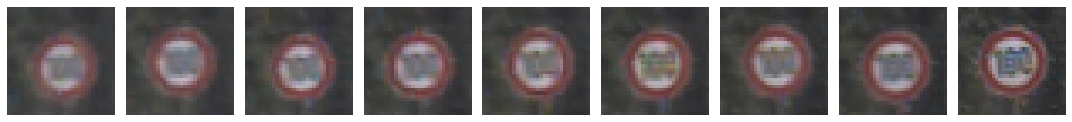

===== Speed limit (120km/h) =====


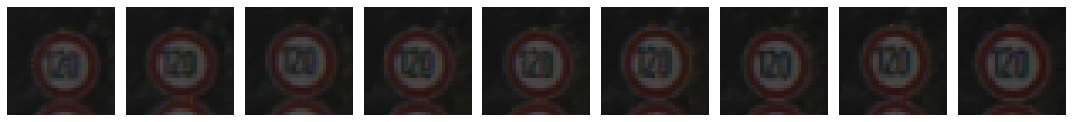

===== No passing =====


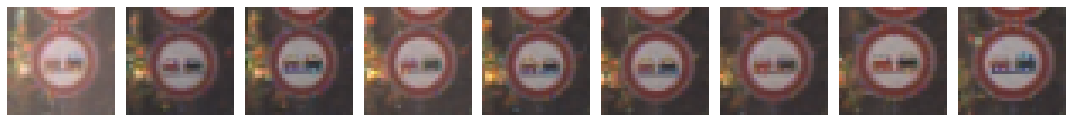

===== No passing for vechiles over 3.5 metric tons =====


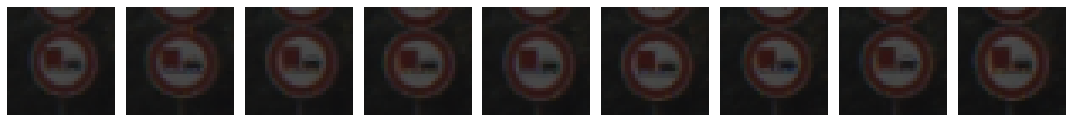

===== Right-of-way at the next intersection =====


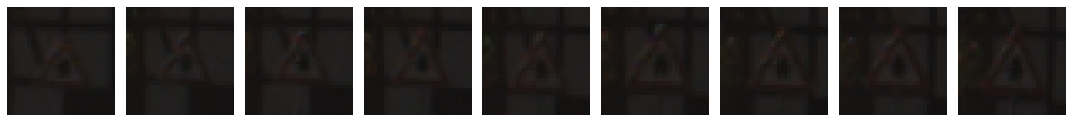

===== Priority road =====


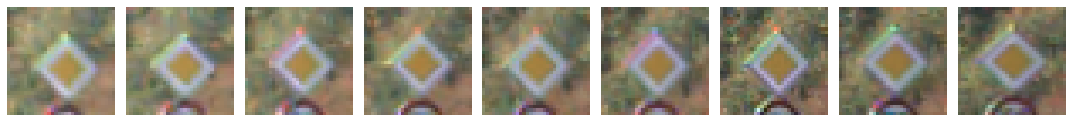

===== Yield =====


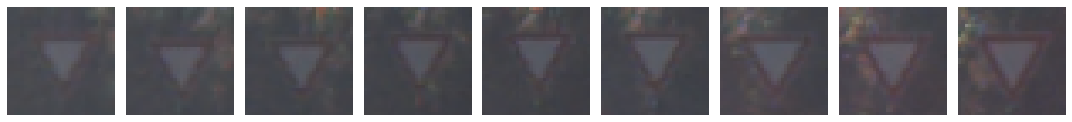

===== Stop =====


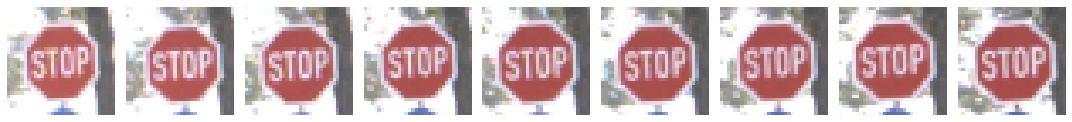

===== No vechiles =====


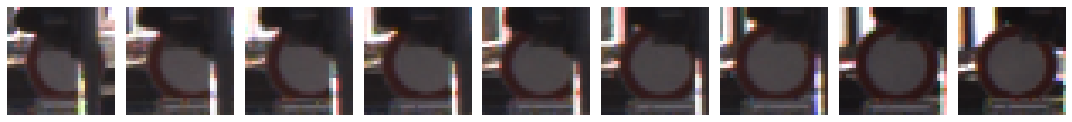

===== Vechiles over 3.5 metric tons prohibited =====


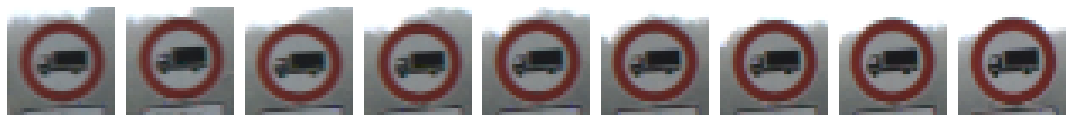

===== No entry =====


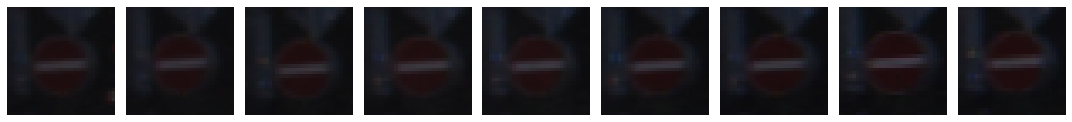

===== General caution =====


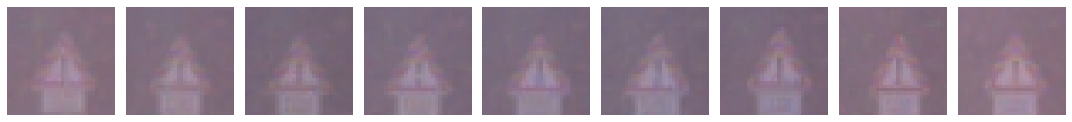

===== Dangerous curve to the left =====


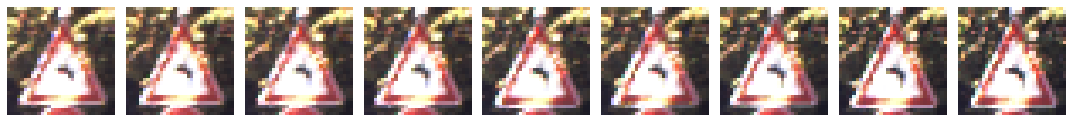

===== Dangerous curve to the right =====


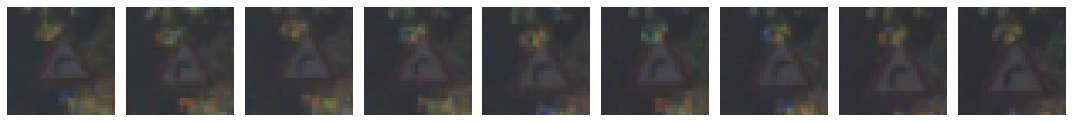

===== Double curve =====


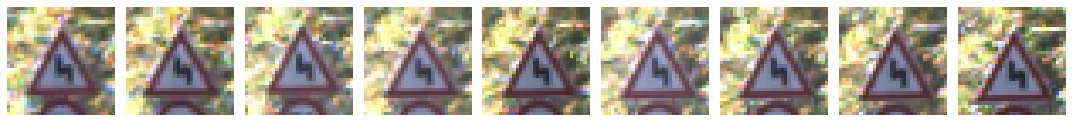

===== Bumpy road =====


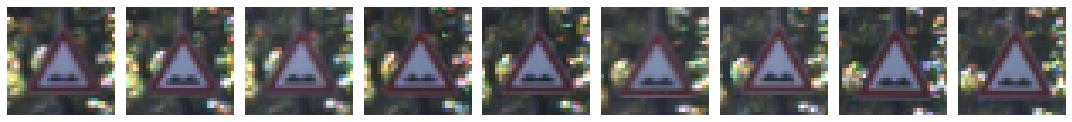

===== Slippery road =====


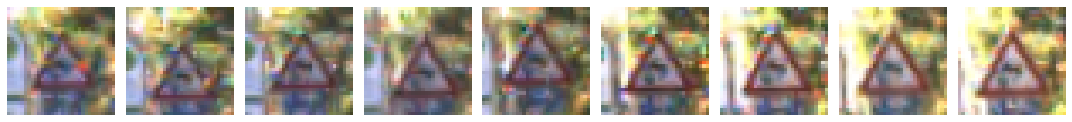

===== Road narrows on the right =====


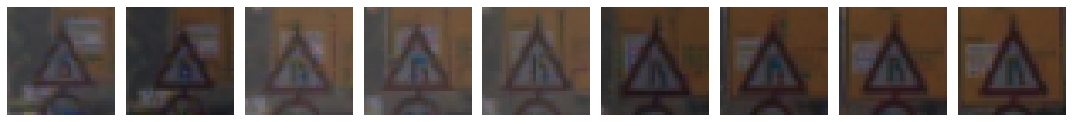

===== Road work =====


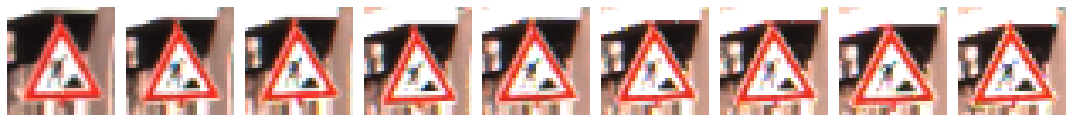

===== Traffic signals =====


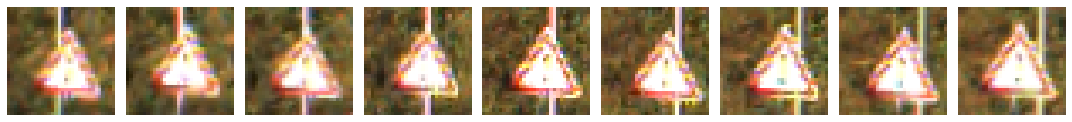

===== Pedestrians =====


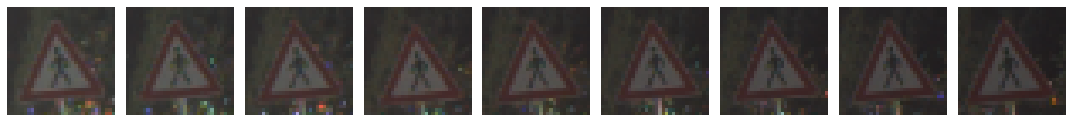

===== Children crossing =====


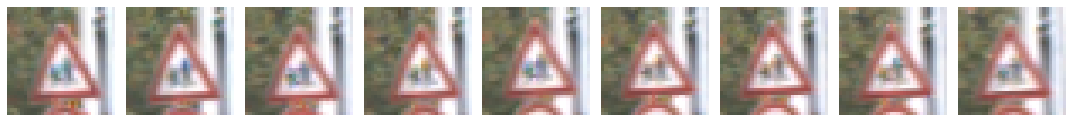

===== Bicycles crossing =====


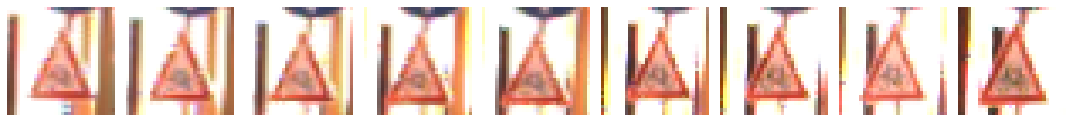

===== Beware of ice/snow =====


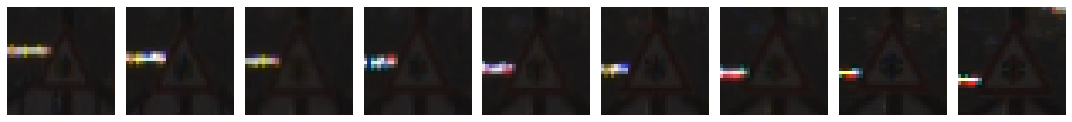

===== Wild animals crossing =====


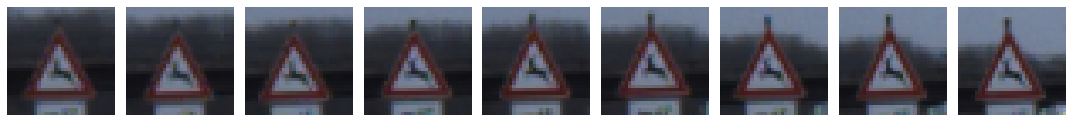

===== End of all speed and passing limits =====


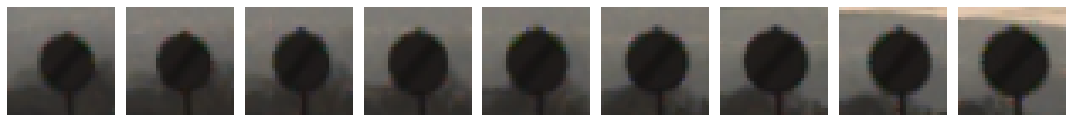

===== Turn right ahead =====


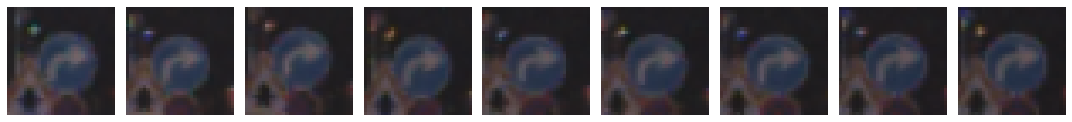

===== Turn left ahead =====


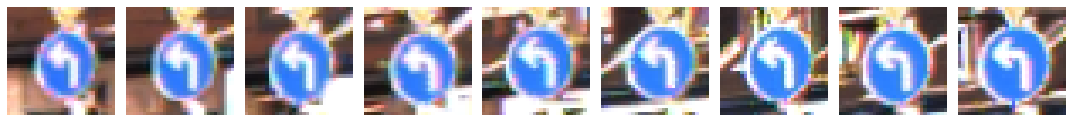

===== Ahead only =====


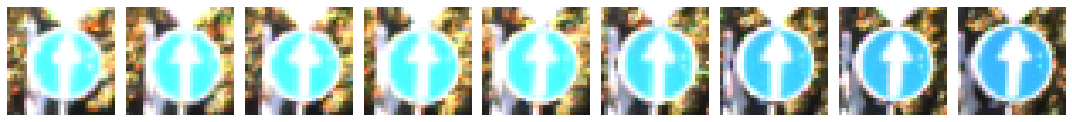

===== Go straight or right =====


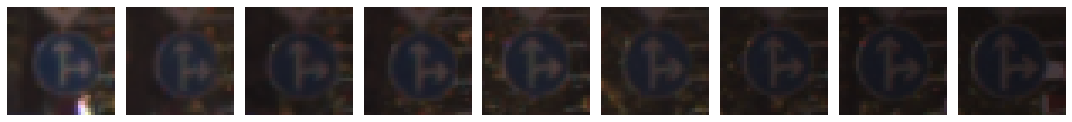

===== Go straight or left =====


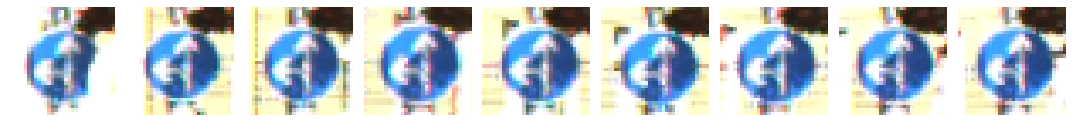

===== Keep right =====


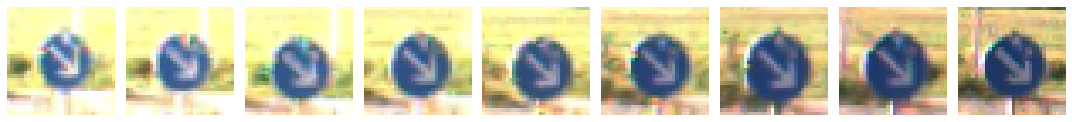

===== Keep left =====


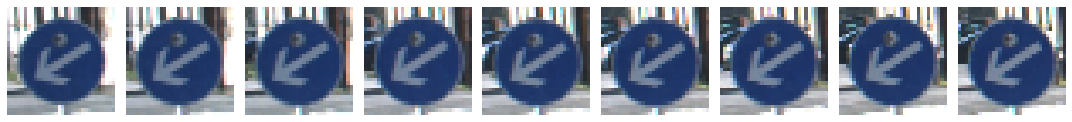

===== Roundabout mandatory =====


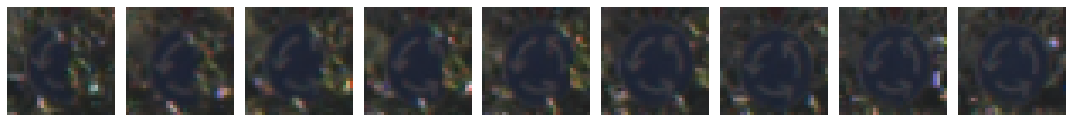

===== End of no passing =====


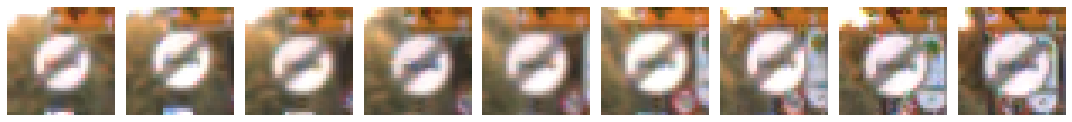

===== End of no passing by vechiles over 3.5 metric tons =====


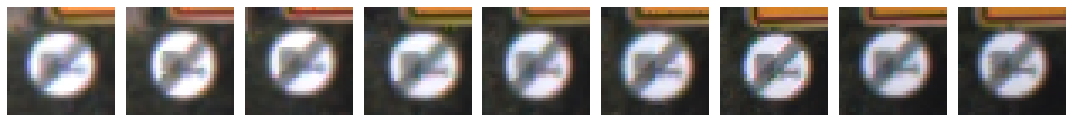

In [0]:
# Wizualizacja znaków
for sign_id in traffic_labels_dict.keys():
    print("===== {0} =====".format(traffic_labels_dict[sign_id]))
    signs = X_train[ y_train == sign_id ]
    
    plt.figure(figsize=(15, 12))
    for idx in range(9):
        plt.subplot("19{0}".format(1 + idx) )
        plt.imshow( signs[idx,])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

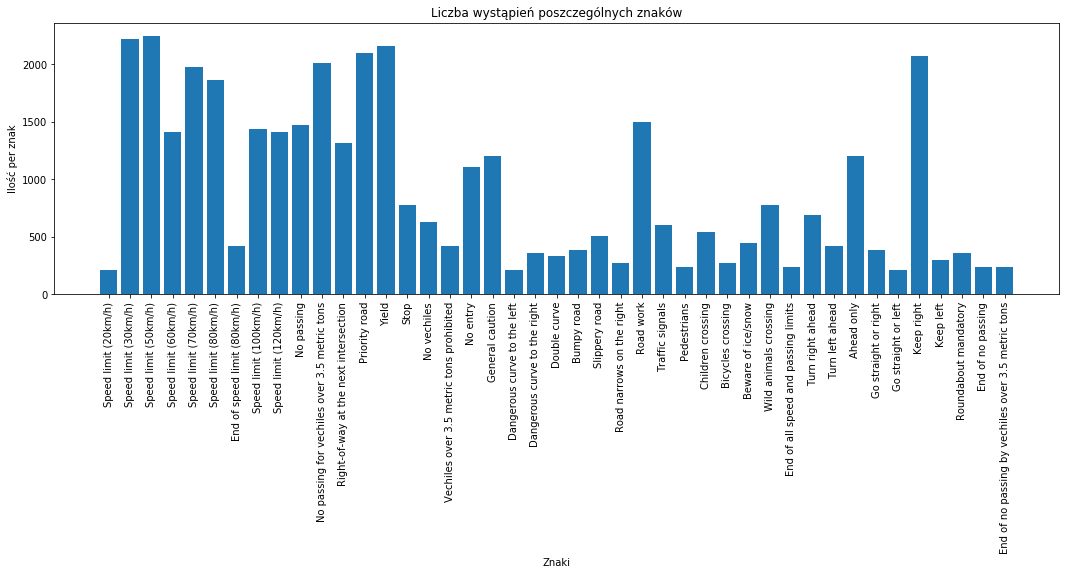

In [0]:
# Liczebność poszczególnych klas
cnt = Counter(y_train)
plt.figure(figsize=(18, 5))
plt.title('Liczba wystąpień poszczególnych znaków')
plt.bar(list(cnt.keys()),list(cnt.values()))
plt.xticks(range(len(traffic_labels_dict)), [x[1] for x in traffic_labels_dict.items()], rotation=90)
plt.show()

Jak widać na powyższym histogramie - dane są porządnie niezbalansowane. Niektóre klasy reprezentowane są przez zmniej niż 200 zdjęć, podczas gdy inne składają się z ponad 2000 przykładów. To oznacza, że nasze dane mogą być obarczone biasem przez klasy, które są reprezentowane przez największą liczbę próbek. 

# Przygotowanie danych  do treningu do dense network

In [0]:
# Przygotowanie danych
X_train_baseline = X_train.reshape(len(X_train), 32*32*3).astype('float32')
X_test_baseline = X_test.reshape(len(X_test), 32*32*3).astype('float32')
y_train_baseline = keras.utils.to_categorical(y_train, num_classes)
y_test_baseline = keras.utils.to_categorical(y_test, num_classes)

# Dense Network
Poniżej przedstawione zostaną wyniki treningu sieci typu dense network, dla różnego typu architektur i danych wejściowych. 

## Architektura #1
W każdym z poniższych przypadków i wariantów architektur zostanie model sekwencyjny: model = Sequential().
Wymiary danych wejściowych są równe odpowiednio (32*32*3,) w przypadku obrazów RGB oraz (32*2*1,) dla danych przetransformowanych do odcieni szarości (jednego kanału).

W każdym analizowanym przypadku stosowano funkcję aktywacji Relu, optymalizator Adam i funkcję kosztu Categorical crossentropy.

In [0]:
# Architektura sieci CNN
def dense_network_architecture():
    return Sequential([
        Dense(128, activation='relu', input_shape=(32*32*3,)),
        BatchNormalization(),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(128, activation='relu'),
        BatchNormalization(),

        Dense(num_classes, activation='softmax')
    ])
  
model = dense_network_architecture()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 128)               393344    
_________________________________________________________________
batch_normalization_32 (Batc (None, 128)               512       
_________________________________________________________________
dense_41 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_33 (Batc (None, 128)               512       
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_34 (Batc (None, 128)              

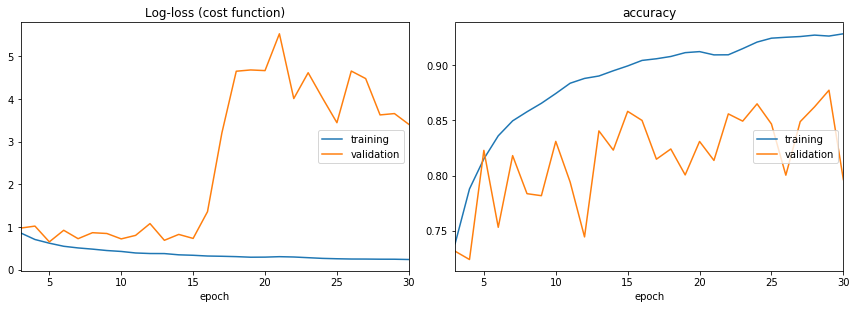

Log-loss (cost function):
training   (min:    0.235, max:    2.607, cur:    0.235)
validation (min:    0.649, max:    5.532, cur:    3.407)

accuracy:
training   (min:    0.300, max:    0.929, cur:    0.929)
validation (min:    0.502, max:    0.877, cur:    0.796)
39209/39209 [==============================] - 5s 123us/sample - loss: 0.2346 - accuracy: 0.9286 - val_loss: 3.4071 - val_accuracy: 0.7964


In [0]:
# Trening
plot_losses = PlotLossesCallback()

history = model.fit(X_train_baseline, y_train_baseline,
          batch_size=128,
          epochs=30,
          verbose=1,
          callbacks=[plot_losses],
          validation_data=(X_test_baseline, y_test_baseline))

The model was able to achieve an accuracy score of 86% without any preprocessing.

### Augmentacja 

Wstępne przetwarzanie danych

Jak przedstawiono to na wykresie obrazującym liczebność klas, widać, że zbiór treningowy jest wyraźnie niezbalansowany. Jedna z metod poradzenia sobie z taka przeszkodą jest augmentacja danych. Możemy ją wykonać na wiele sposobów i z wykorzystaniem różnych bibliotek (https://towardsdatascience.com/exploring-image-data-augmentation-with-keras-and-tensorflow-a8162d89b844).

Poniżej przedstawiono kilka typowych modyfikacji obrazów służących zwierlokrotnieniu i zróżnicowaniu danych, a w szczególności: obrót (o kąt +/-10 stopni), translację oraz filtrację.

In [6]:
rows, cols = X_train.shape[1], X_train.shape[2]
print('Number of rows:', rows, 'Number of cols',cols)

Number of rows: 32 Number of cols 32


In [0]:
M_rot = cv2.getRotationMatrix2D((cols/2,rows/2),10,1)

In [0]:
def data_augment(image):  
    # rotation
    M_rot = cv2.getRotationMatrix2D((cols/2,rows/2),10,1)
    
    # Translation
    M_trans = np.float32([[1,0,3],[0,1,6]])
    
    
    img = cv2.warpAffine(image,M_rot,(cols,rows))
    img = cv2.warpAffine(img,M_trans,(cols,rows))
        
    # Bilateral filtering
    img = cv2.bilateralFilter(img,9,75,75)
    return img

In [0]:
# Wykonanie augmentacji
classes=43
X_train_final = X_train
y_train_final = y_train
X_aug_1 = []
Y_aug_1 = []

for i in range(0,classes):
    
    class_records = np.where(y_train==i)[0].size
    max_records = 4000
    if class_records != max_records:
        ovr_sample = max_records - class_records
        samples = X_train[np.where(y_train==i)[0]]
        X_aug = []
        Y_aug = [i] * ovr_sample
        
        for x in range(ovr_sample):
            img = samples[x % class_records]
            trans_img = data_augment(img)
            X_aug.append(trans_img)
            
        X_train_final = np.concatenate((X_train_final, X_aug), axis=0)
        y_train_final = np.concatenate((y_train_final, Y_aug)) 
        
        Y_aug_1 = Y_aug_1 + Y_aug
        X_aug_1 = X_aug_1 + X_aug
    

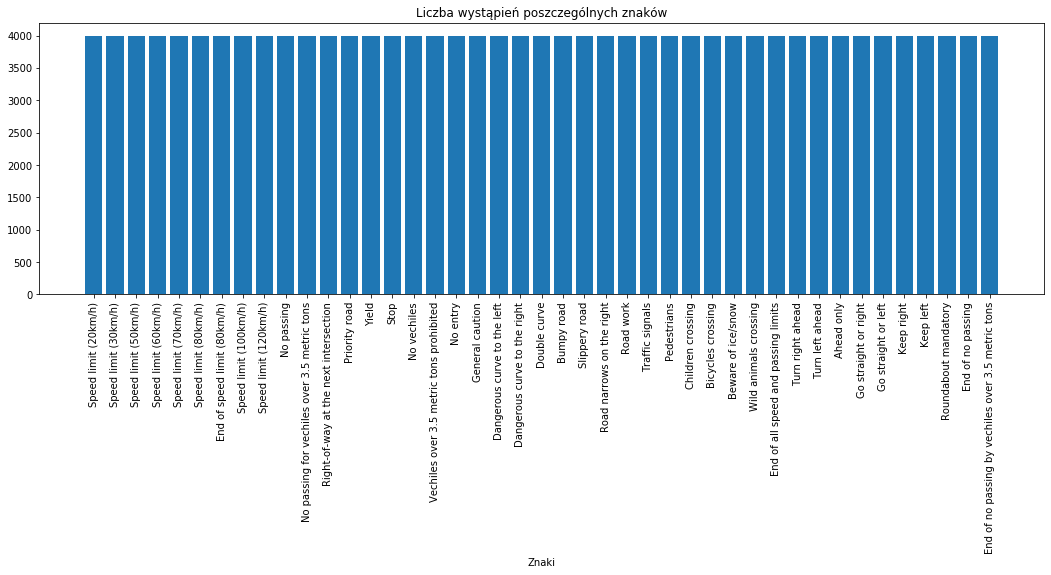

In [0]:
# Rozkład danych po augmentacji
cnt = Counter(y_train_final)
plt.figure(figsize=(18, 5))
plt.title('Liczba wystąpień poszczególnych znaków')
plt.bar(list(cnt.keys()),list(cnt.values()))
plt.xlabel('Znaki')
plt.xticks(range(len(traffic_labels_dict)), [x[1] for x in traffic_labels_dict.items()], rotation=90)
plt.show()

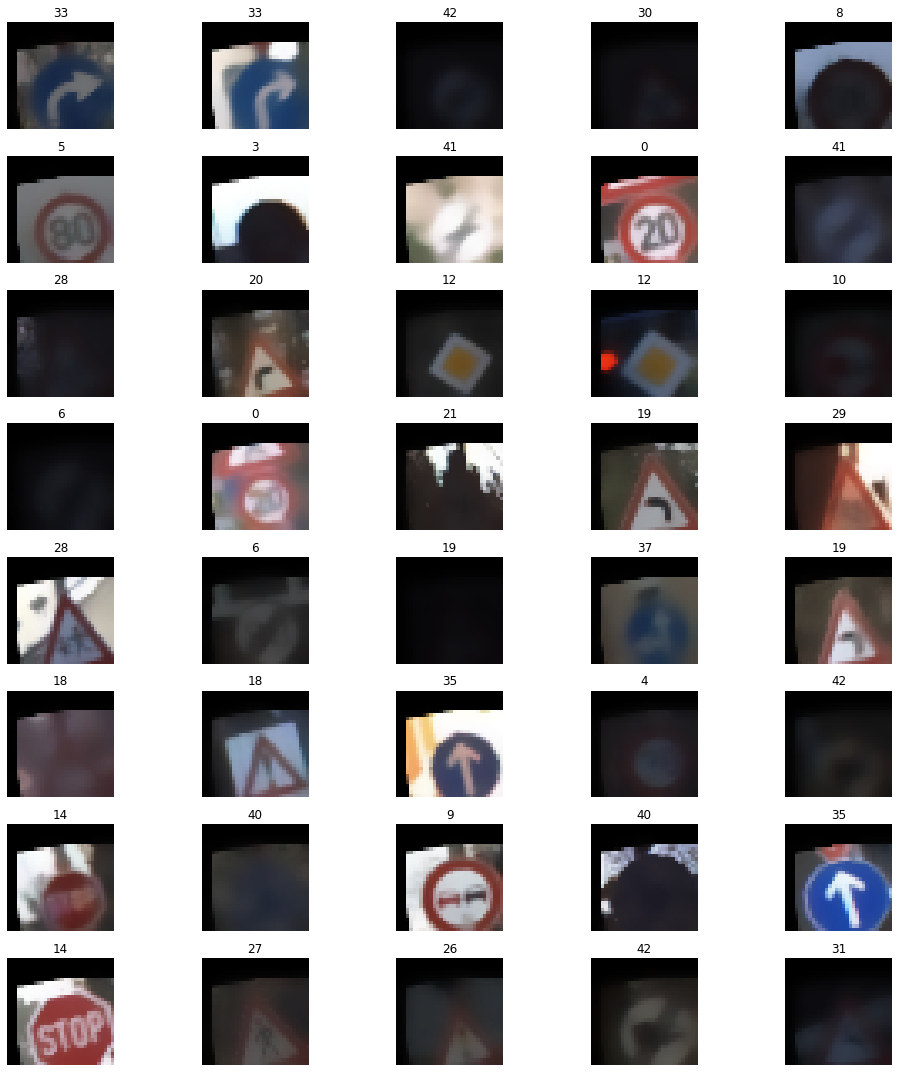

In [0]:
# Wizualizacja znaków po augmentacji
import random
fig, axs = plt.subplots(8,5, figsize=(15, 15))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(40):
    index = random.randint(0, len(X_aug_1))
    image = X_aug_1[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(Y_aug_1[index])
plt.tight_layout()

## Architektura #2

In [0]:
# Przygotowanie danych
num_classes=len(Counter(y_train_final))
X_train_baseline = X_train_final.reshape(len(X_train_final), 32*32*3).astype('float32')
X_test_baseline = X_test.reshape(len(X_test), 32*32*3).astype('float32')
y_train_baseline = keras.utils.to_categorical(y_train_final, num_classes)
y_test_baseline = keras.utils.to_categorical(y_test, num_classes)

In [12]:
X_train_final.shape, y_train_final.shape

((172000, 32, 32, 3), (172000,))

In [13]:
X_train_baseline.shape, y_train_baseline.shape

((172000, 3072), (172000, 43))

In [0]:
# Architektura sieci 
def dense_network_architecture():
    return Sequential([
        Dense(128, activation='relu', input_shape=(32*32*3,)),
        BatchNormalization(),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(128, activation='relu'),
        BatchNormalization(),

        Dense(num_classes, activation='softmax')
    ])
  
model = dense_network_architecture()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 128)               393344    
_________________________________________________________________
batch_normalization_40 (Batc (None, 128)               512       
_________________________________________________________________
dense_55 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_41 (Batc (None, 128)               512       
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_42 (Batc (None, 128)             

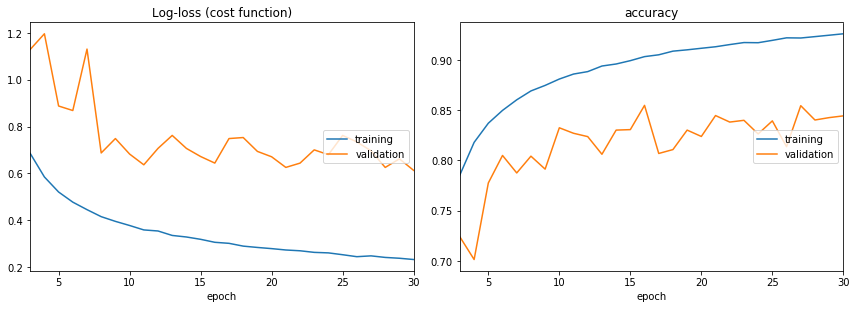

Log-loss (cost function):
training   (min:    0.233, max:    1.870, cur:    0.233)
validation (min:    0.613, max:    1.742, cur:    0.613)

accuracy:
training   (min:    0.455, max:    0.926, cur:    0.926)
validation (min:    0.529, max:    0.855, cur:    0.844)
172000/172000 [==============================] - 18s 106us/sample - loss: 0.2329 - accuracy: 0.9262 - val_loss: 0.6133 - val_accuracy: 0.8444


In [0]:
# Trening
plot_losses = PlotLossesCallback()

history = model.fit(X_train_baseline, y_train_baseline,
          batch_size=128,
          epochs=30,
          verbose=1,
          callbacks=[plot_losses],
          validation_data=(X_test_baseline, y_test_baseline))

### Transformacja do skali szarości

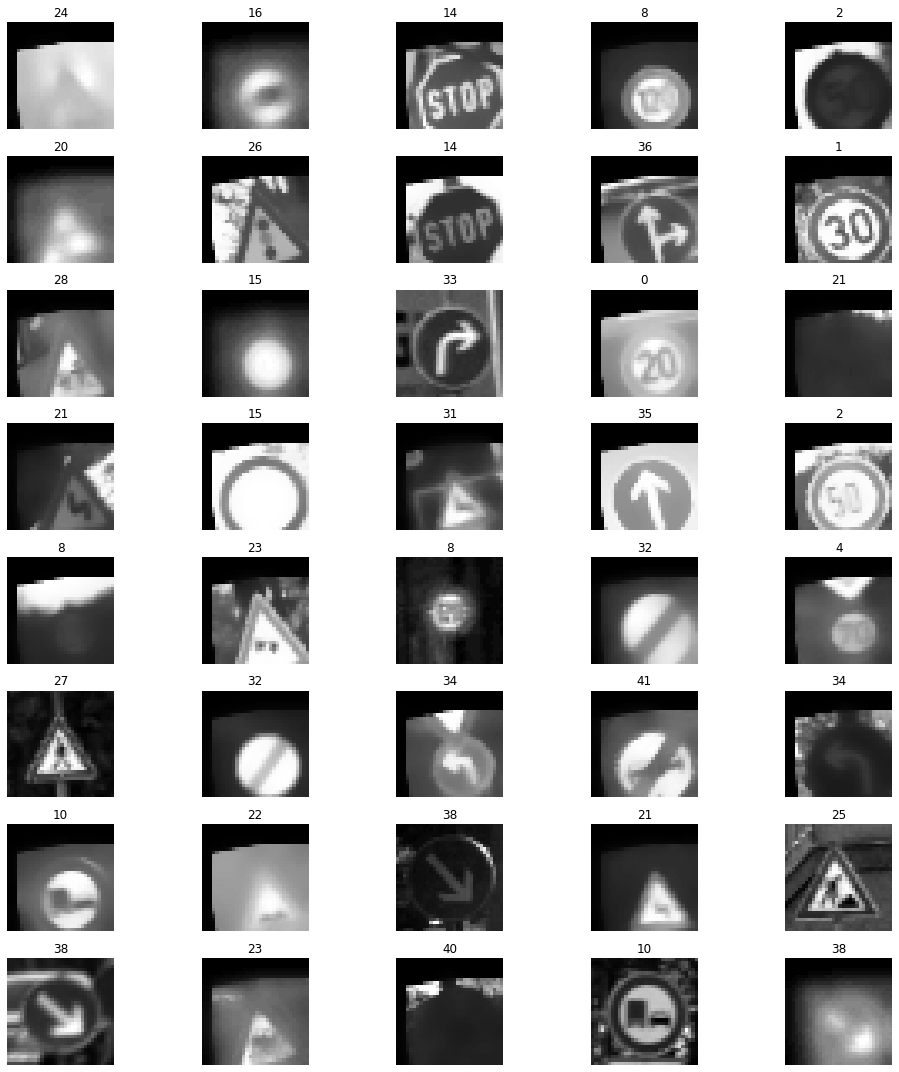

In [14]:
def gray_scale(image):
    
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

gray_images_data = list(map(gray_scale, X_train_final))


fig, axs = plt.subplots(8,5, figsize=(15, 15))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(40):
    index = np.random.randint(0, len(gray_images_data))
    image = gray_images_data[index]
    axs[i].axis('off')
    axs[i].imshow(image,cmap='gray')
    axs[i].set_title(y_train_final[index])
plt.tight_layout()

### Wyrównanie histogramów

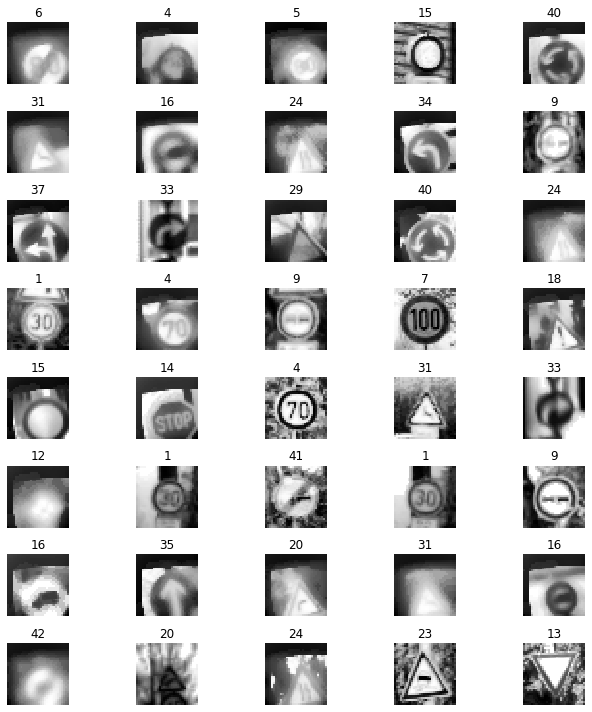

In [15]:
import skimage.morphology as morp
from skimage.filters import rank

def local_histo_equalize(image):
    
    kernel = morp.disk(30)
    img_local = rank.equalize(image, selem=kernel)
    return img_local


local_histo = np.array(list(map(local_histo_equalize, gray_images_data)))

fig, axs = plt.subplots(8,5, figsize=(10, 10))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(40):
    index = np.random.randint(0, len(local_histo))
    image = local_histo[index]
    axs[i].axis('off')
    axs[i].imshow(image,cmap = 'gray')
    axs[i].set_title(y_train_final[index])
plt.tight_layout()

In [0]:
def preprocess(data):
    gray_images = list(map(gray_scale, data))
    equalized_images = list(map(local_histo_equalize, gray_images))
    n_training = data.shape
    normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
    for i, img in enumerate(equalized_images):
        normalized_images[i] = np.divide(img,255)
    normalized_images = normalized_images[..., None]
    return normalized_images

## Architektura #3

In [0]:
X_train_preprocessed = preprocess(X_train_final)
X_test_preprocessed = preprocess(X_test)

In [0]:
X_train_preprocessed_dn = X_train_preprocessed.reshape(len(X_train_preprocessed), 32*32*1).astype('float32')
X_test_preprocessed_dn = X_test_preprocessed.reshape(len(X_test_preprocessed), 32*32*1).astype('float32')

In [0]:
y_train_final_dn = keras.utils.to_categorical(y_train_final, num_classes)
y_test_final_dn = keras.utils.to_categorical(y_test, num_classes)

In [0]:
print(X_train_preprocessed_dn.shape)
print(X_test_preprocessed_dn.shape)
print(y_train_final_dn.shape)
print(y_test_final_dn.shape)

(172000, 1024)
(12630, 1024)
(172000, 43)
(12630, 43)


In [0]:
# Architektura sieci dense network
def dense_network_architecture():
    return Sequential([
        Dense(128, activation='relu', input_shape=(32*32*1,)),
        BatchNormalization(),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(128, activation='relu'),
        BatchNormalization(),

        Dense(num_classes, activation='softmax')
    ])
  
model = dense_network_architecture()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 128)               131200    
_________________________________________________________________
batch_normalization_44 (Batc (None, 128)               512       
_________________________________________________________________
dense_60 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_45 (Batc (None, 128)               512       
_________________________________________________________________
dropout_26 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_46 (Batc (None, 128)             

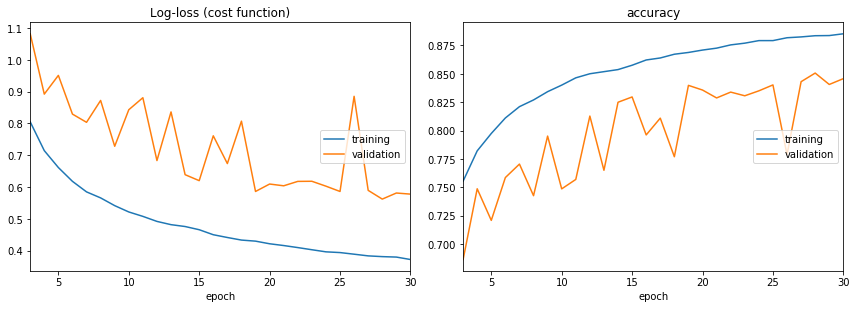

Log-loss (cost function):
training   (min:    0.372, max:    1.752, cur:    0.372)
validation (min:    0.562, max:    1.559, cur:    0.578)

accuracy:
training   (min:    0.501, max:    0.885, cur:    0.885)
validation (min:    0.538, max:    0.851, cur:    0.846)
172000/172000 [==============================] - 13s 75us/sample - loss: 0.3723 - accuracy: 0.8853 - val_loss: 0.5778 - val_accuracy: 0.8458


In [0]:
# Trening
plot_losses = PlotLossesCallback()

history = model.fit(X_train_preprocessed_dn, y_train_final_dn,
          batch_size=128,
          epochs=30,
          verbose=1,
          callbacks=[plot_losses],
          validation_data=(X_test_preprocessed_dn, y_test_final_dn))

# Przygotowanie danych do CNN

In [0]:
 # Prepare data for Conv nets
X_train_preprocessed_cn = X_train_preprocessed.reshape(len(X_train_preprocessed), 32,32,1).astype('float32')
X_test_preprocessed_cn = X_test_preprocessed.reshape(len(X_test_preprocessed), 32,32,1).astype('float32')

In [0]:
y_train_final_cn = keras.utils.to_categorical(y_train_final, num_classes)
y_test_final_cn = keras.utils.to_categorical(y_test, num_classes)

In [0]:
# Zapis danych do uczenia CNN
np.save('/content/drive/My Drive/german_traffic_signs/X_train_CNN_german.npy', X_train_preprocessed_cn)
np.save('/content/drive/My Drive/german_traffic_signs/y_train_CNN_german.npy', y_train_final_cn)
np.save('/content/drive/My Drive/german_traffic_signs/X_test_CNN_german.npy', X_test_preprocessed_cn)
np.save('/content/drive/My Drive/german_traffic_signs/y_test_CNN_german.npy', y_test_final_cn)

In [0]:
# Pobranie danych z google drive
X_train = np.load('/content/drive/My Drive/german_traffic_signs/X_train_CNN_german.npy')
y_train = np.load('/content/drive/My Drive/german_traffic_signs/y_train_CNN_german.npy')
X_test = np.load('/content/drive/My Drive/german_traffic_signs/X_test_CNN_german.npy')
y_test = np.load('/content/drive/My Drive/german_traffic_signs/y_test_CNN_german.npy')

input_shape = X_train.shape[1:]

# CNN

## Architektura #1

In [0]:
# Architektura sieci CNN
def single_3layer_cnn_no_dropout():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPool2D(pool_size=(2, 2)),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2, 2)),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2, 2)),
        
        Flatten(),
        
        Dense(1048, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
  
model = single_3layer_cnn_no_dropout()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)            

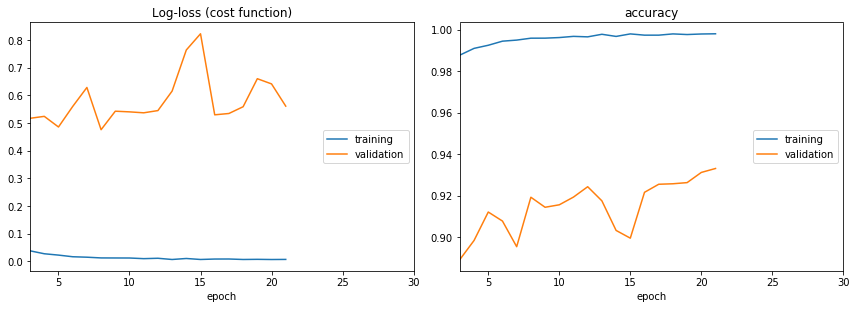

Log-loss (cost function):
training   (min:    0.007, max:    0.621, cur:    0.007)
validation (min:    0.476, max:    0.822, cur:    0.561)

accuracy:
training   (min:    0.825, max:    0.998, cur:    0.998)
validation (min:    0.846, max:    0.933, cur:    0.933)
172000/172000 [==============================] - 403s 2ms/sample - loss: 0.0073 - accuracy: 0.9980 - val_loss: 0.5607 - val_accuracy: 0.9331
Epoch 22/30
115456/172000 [===================>..........] - ETA: 2:09 - loss: 0.0066 - accuracy: 0.9980

In [0]:
# Trening
plot_losses = PlotLossesCallback()

history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=30,
          verbose=1,
          callbacks=[plot_losses],
          validation_data=(X_test, y_test))

## Architektura #2

In [29]:
# Architektura sieci CNN
def triple_mixed_conv_dropout():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        BatchNormalization(),
        Dropout(0.25),

        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        BatchNormalization(),
        Dropout(0.5),

        Flatten(),
        
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
  
model = triple_mixed_conv_dropout()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       36992     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 6, 128)         5

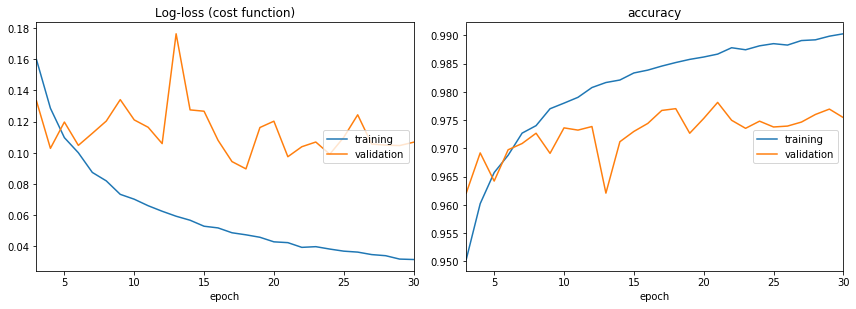

Log-loss (cost function):
training   (min:    0.032, max:    1.228, cur:    0.032)
validation (min:    0.090, max:    0.290, cur:    0.107)

accuracy:
training   (min:    0.652, max:    0.990, cur:    0.990)
validation (min:    0.913, max:    0.978, cur:    0.975)
172000/172000 [==============================] - 25s 144us/sample - loss: 0.0317 - accuracy: 0.9903 - val_loss: 0.1068 - val_accuracy: 0.9755


In [30]:
# Trening
history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=30,
          verbose=1,
          callbacks=[PlotLossesCallback()],
          validation_data=(X_test, y_test))

Dokładność duża, ale overfitting jeszcze większy... Próbujemy z inną architekturą...

## Architektura #3

In [31]:
# Architektura sieci CNN
def three_doubled_conv_cnn_with_dropout():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
      
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Flatten(),
        
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])


model = three_doubled_conv_cnn_with_dropout()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)         

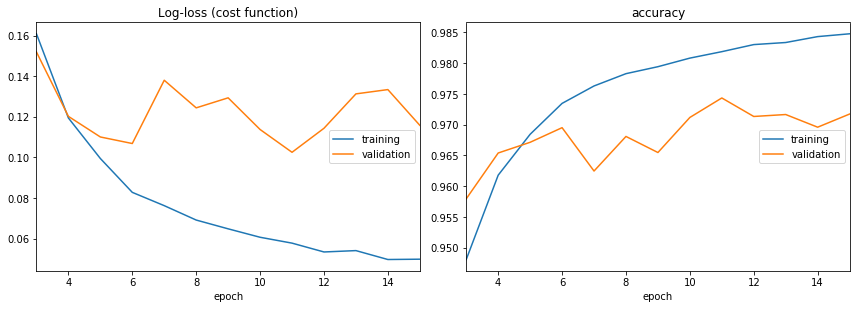

Log-loss (cost function):
training   (min:    0.050, max:    1.436, cur:    0.050)
validation (min:    0.102, max:    0.324, cur:    0.116)

accuracy:
training   (min:    0.580, max:    0.985, cur:    0.985)
validation (min:    0.903, max:    0.974, cur:    0.972)
172000/172000 [==============================] - 17s 97us/sample - loss: 0.0498 - accuracy: 0.9848 - val_loss: 0.1158 - val_accuracy: 0.9717


In [32]:
# Trening
history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=15,
          verbose=1,
          callbacks=[PlotLossesCallback()],
          validation_data=(X_test, y_test))

## Architektura #4

In [65]:
# Architektura sieci CNN
def three_doubled_conv_cnn_with_dropout():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.5),

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.5),
      
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.5),
        
        Flatten(),
        
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])


model = three_doubled_conv_cnn_with_dropout()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_70 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 6, 6, 64)        

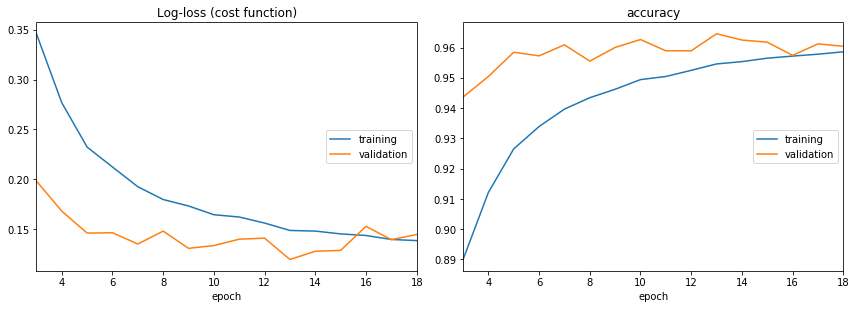

Log-loss (cost function):
training   (min:    0.138, max:    1.882, cur:    0.138)
validation (min:    0.119, max:    0.546, cur:    0.144)

accuracy:
training   (min:    0.465, max:    0.959, cur:    0.959)
validation (min:    0.828, max:    0.965, cur:    0.960)
172000/172000 [==============================] - 16s 95us/sample - loss: 0.1382 - accuracy: 0.9586 - val_loss: 0.1443 - val_accuracy: 0.9604


In [64]:
# Trening
history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=18,
          verbose=1,
          callbacks=[PlotLossesCallback()],
          validation_data=(X_test, y_test))

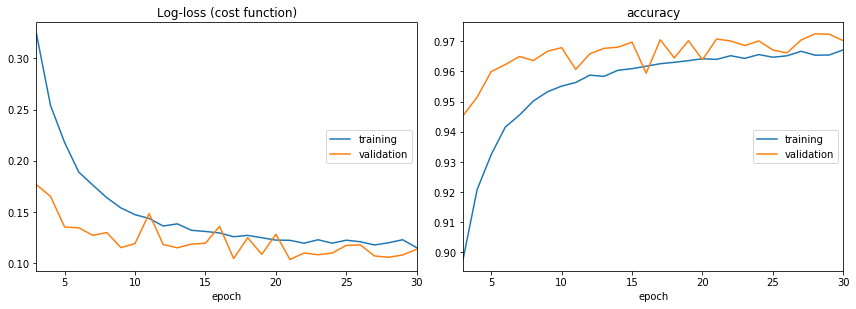

Log-loss (cost function):
training   (min:    0.115, max:    1.768, cur:    0.115)
validation (min:    0.103, max:    0.497, cur:    0.113)

accuracy:
training   (min:    0.481, max:    0.967, cur:    0.967)
validation (min:    0.839, max:    0.972, cur:    0.970)
172000/172000 [==============================] - 16s 96us/sample - loss: 0.1149 - accuracy: 0.9671 - val_loss: 0.1135 - val_accuracy: 0.9702


In [66]:
# Trening
history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=30,
          verbose=1,
          callbacks=[PlotLossesCallback()],
          validation_data=(X_test, y_test))

In [67]:
# Sprawdzenie dokładności predykcji na zbiorze testowym
score = model.evaluate(X_test, y_test, verbose=0)

print("Test loss: %.2f%%" % (100*score[0]))
print("Test accuracy: %.2f%%" % (100*score[1]))
print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 11.35%
Test accuracy: 97.02%
CNN Error: 2.98%


# Gdzie się mylimy?

In [0]:
y_pred = model.predict(X_test)

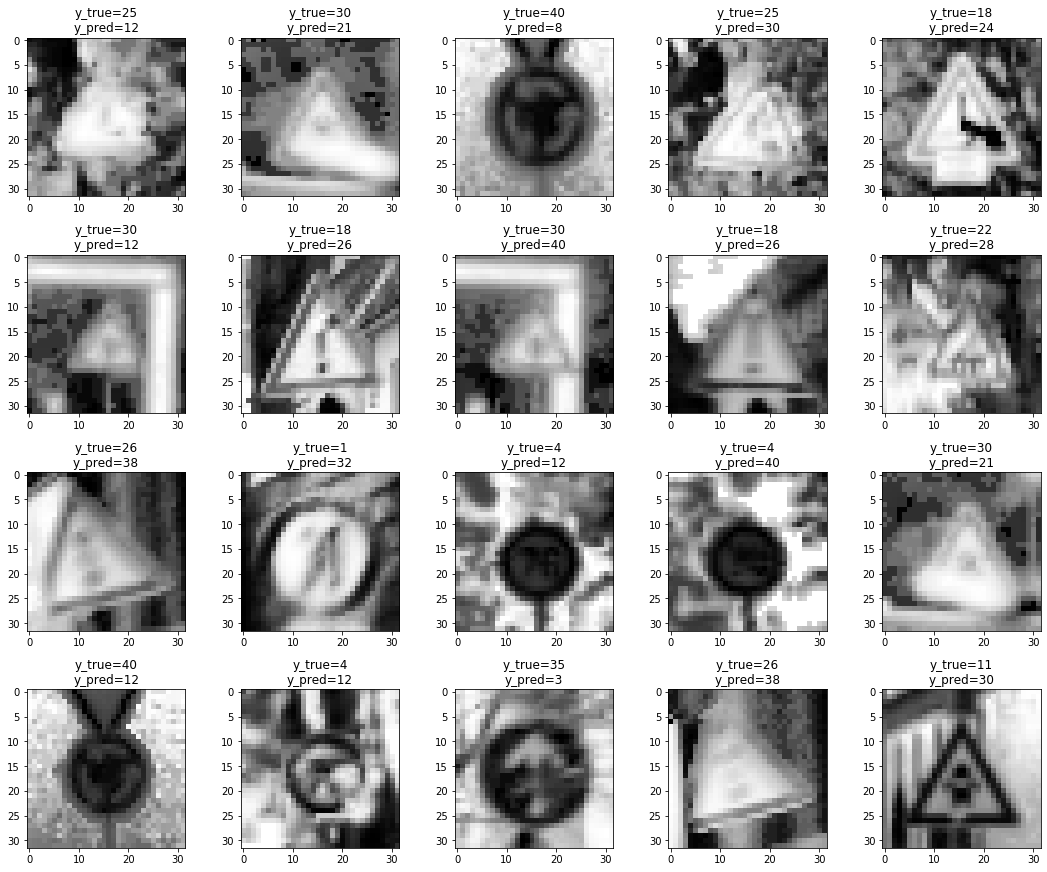

In [72]:
def get_diff(y_test, y_pred):
    for idx, (a, b) in enumerate(zip(y_test, y_pred)):
        if np.argmax(a) == np.argmax(b): continue
        yield idx, np.argmax(a), np.argmax(b)

limit = 19
cur_limit = 0
fig = plt.figure(figsize=(15, 15))
X_test_plot = X_test.reshape( X_test.shape[:-1] )

for it, (idx, y_test_val, y_pred_val) in enumerate(get_diff(y_test, y_pred)):
    if cur_limit > limit: break
      
    plt.subplot(5,5,it+1)
    plt.imshow(X_test_plot[idx], cmap='gray', interpolation='none')
    plt.title('y_true={0}\ny_pred={1}'.format(y_test_val, y_pred_val))
    plt.tight_layout()
        
    cur_limit += 1